In [117]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

##국회의원 페이지는 ajax 통신을 통해 함
url = 'https://www.assembly.go.kr/assm/memact/congressman/memCond/memCondListAjax.do'
req_param_dict = {
    'currentPage':1,
    'rowPerPage':500

}

res = requests.get(url,params=req_param_dict)
# print(res.status_code)

if res.ok:
    soup = BeautifulSoup(res.text,'html.parser')
    # print(len(soup.select('div.memberna_list dl dt a'))) #div -> dl -> dt -> a 순서로 내려감
    atag_list = soup.select('div.memberna_list dl dt a')
    member_id_list = []
    for atag in atag_list:
        href = atag['href'] #javascript:jsMemPop('9771230') #regexr.com 으로 고고 #내용 붙여넣어서 정규표현식 찾음
        # print(href)
        matched = re.search(r'(\d+)',href)
        # print(matched.group(0))
        if matched:
            member_id = matched.group(0) #국회의원 번호를 찾음
        member_id_list.append(member_id)
    print(len(member_id_list))
    print(member_id_list[:3])




295
['9771230', '9771142', '9771174']


In [118]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urljoin  ##사진을 위해

print('--> 스크래핑 시작')
member_detail_list = [] #국회의원 상세정보를 위한 list

for idx,mem_id in enumerate(member_id_list,1):
    detail_url = f'https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd={mem_id}'
    print(idx,detail_url)
    res = requests.get(detail_url)
    if res.ok:
        soup = BeautifulSoup(res.text,'html.parser')
        # print(soup)

        #1명의 정보를 저장할 dict 선언
        member_detail_dict = {}
        #국회의원 소개 페이지에서 오른쪽에 (정당,선거구,소속위원회..) = 1개리스트 | (국민의힘,대구 동구을,,,) = 1개 리스트 해서 하나로 합친다(zip)
        #dt 태그와 dd 태그 존재
        # print(len(soup.select('dl.pro_detail dt')))
        # print(len(soup.select('dl.pro_detail dd')))




        dt_list = []
        dd_list = []

        for dt_tag in soup.select('dl.pro_detail dt'):

            pattern = re.compile(f'[\n\r\t]') #특수문자 제거를 위한 패턴을 만듬
            dt_text = pattern.sub('',dt_tag.text.strip())
            dt_list.append(dt_text)

        # print(dt_list)
        for dd_tag in soup.select('dl.pro_detail dd'):
            dd_text = pattern.sub('',dd_tag.text.strip()).replace(" ","") ##중간에 빈공백이 남아있어서 중간에 있는 빈 공백을 제거한다 replace(찾을거,대체할거)
            dd_list.append(dd_text)
        # print(dd_list)

        member_detail_dict = dict(zip(dt_list,dd_list)) #dt태그 list와 dd태그 list를 딕셔너리에 zip함수로 묶는다


        for div_tag in soup.select('div.profile'):
            # print(div_tag.find('h4').text) ###태그 밑에있는 태그를 찾을때 find함수 사용
            member_detail_dict['이름'] = div_tag.find('h4').text #딕셔너리에 이름 이라는 태그로 넣기

            img_tag = div_tag.select('img')


            if img_tag:
                # member_detail_dict['이미지'] = img_tag_list[0]
                # print(img_tag[0]['src'])
                member_detail_dict['이미지'] = urljoin(detail_url,img_tag[0]['src']) ##이미지태그에서 src 값을 딕셔너리에 넣는다.
                                                                                    ## urljoin을 안써도 되지만 src값이 없는경우를 대비해서 안전하게 함!
            # print(div_tag.select_one('li:nth-of-type(4)').text) ##css selector nth-of-type : filter 해주는거
            member_detail_dict['생년월일'] = div_tag.select_one('li:nth-of-type(4)').text
        member_detail_list.append(member_detail_dict) #1명이 저장되어있는 member_detail_dict를 member_detail_list에 추가합니다.
        # print(member_detail_dict)

print(len(member_detail_list))
print('--->스크래핑 끝')



--> 스크래핑 시작
1 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771230
2 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771142
3 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771174
4 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771233
5 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771283
6 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770933
7 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771116
8 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771276
9 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771168
10 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771007
11 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771109
12 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771180
13 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9770931
14 https://www.assembly.go.kr/assm/memPop/memPopup.do?dept_cd=9771224
15 https://www.as

## json으로 만들어서 DataFrame으로 만들기

In [119]:
import json

with open('data/member.json','w') as file: #파일만들기
    json.dump(member_detail_list,file,ensure_ascii=False)  #member_detail_list를 json파일로 만듬

In [175]:
import pandas as pd

members_df = pd.read_json('data/member.json')
print(members_df.shape)

(295, 16)


In [176]:
members_df['정당']

0        국민의힘
1        국민의힘
2      더불어민주당
3        국민의힘
4      더불어민주당
        ...  
290    더불어민주당
291      국민의힘
292      국민의힘
293    더불어민주당
294    더불어민주당
Name: 정당, Length: 295, dtype: object

In [177]:
members_df['정당'].value_counts() #정당별 count

더불어민주당    172
국민의힘      106
정의당         6
무소속         6
국민의당        3
기본소득당       1
시대전환        1
Name: 정당, dtype: int64

In [178]:
members_df['당선횟수'].value_counts() #몇번당선됐나?

초선(21대)                        149
재선(20대,21대)                     60
3선(19대,20대,21대)                 33
4선(17대,19대,20대,21대)             10
재선(19대,21대)                      9
5선(17대,18대,19대,20대,21대)          7
4선(18대,19대,20대,21대)              6
3선(18대,19대,21대)                  3
재선(17대,21대)                      2
4선(16대,17대,18대,21대)              2
5선(16대,17대,18대,20대,21대)          2
3선(17대,19대,21대)                  2
3선(18대,20대,21대)                  2
4선(17대,18대,19대,21대)              1
3선(15대,16대,21대)                  1
6선(16대,17대,18대,19대,20대,21대)      1
5선(16대,17대,18대,19대,21대)          1
5선(15대,16대,19대,20대,21대)          1
3선(17대,18대,21대)                  1
재선(18대,21대)                      1
5선(15대,16대,17대,18대,21대)          1
Name: 당선횟수, dtype: int64

In [179]:
# members_df['선거구'].value_counts()
members_df.head()

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일
0,국민의힘,경남창원시성산구,보건복지위원회,"재선(19대,21대)",02-784-1751,의원회관937호,http://blog.naver.com/ggotop,ggotop@naver.com,"김홍광,한영애","지상훈,최광림","김영록,안효상,이유진,홍지형,김지훈",,,강기윤,https://www.assembly.go.kr/photo/9771230.jpg,1960-06-04
1,국민의힘,대구동구을,"국방위원회,정치개혁특별위원회",초선(21대),02-784-5275,의원회관341호,,kds21341@naver.com,"박홍규,정운태","유진영,윤미라","박순권,김광연,김현정,송민욱",,,강대식,https://www.assembly.go.kr/photo/9771142.jpg,1959-11-02
2,더불어민주당,경기안양시만안구,"교육위원회,예산결산특별위원회",초선(21대),02-784-2747~9,의원회관440호,https://blog.naver.com/dulipapa,mainsail440@daum.net,"서용선,안홍식","최경순,홍미하","문형구,최기섭,조나연,오세령,배은경",,강득구의원의'사람중심민생중심'의정활동이국민의삶에힘이되도록열심히하고있습니다.강득구의원...,강득구,https://www.assembly.go.kr/photo/9771174.jpg,1963-05-27
3,국민의힘,경남진주시을,"국회운영위원회,정무위원회,중앙선거관리위원회위원(문상부)선출에관한인사청문특별위원회,정...",초선(21대),02-784-0797,의원회관1007호,,strongwind01@naver.com,"강민승,정경섭","국고은,오경훈","성환종,사정아,김오주,박정헌,한지은",,,강민국,https://www.assembly.go.kr/photo/9771233.jpg,1971-03-03
4,더불어민주당,비례대표,"국회운영위원회,교육위원회,예산결산특별위원회",초선(21대),02-784-2477,의원회관421호,https://blog.naver.com/kmgedu21,kmj2020edu@gmail.com,"손성조,윤호숙","김민혜,김원석","김수안,김성용,민지홍,황연미,양진영",,,강민정,https://www.assembly.go.kr/photo/9771283.jpg,1961-04-26


In [180]:
##당선횟수2 칼럼을 새로 추가 재선(20대,21대) -> 재선 으로 만들것임

print(type(members_df['당선횟수'])) #<class 'pandas.core.series.Series'>
print(type(members_df['당선횟수'].str)) #<class 'pandas.core.strings.accessor.StringMethods'>

#series객체를 stringmethod 객체로 변환해야한다 -> 문자열 슬라이싱을 하기 위해
temp_str = members_df['당선횟수'].str
members_df['당선횟수2'] = temp_str[:2] #members_df에 당선횟수2 컬럼을 만들고 stringmethod로 변환된 temp_str에 두글자만 자름

members_df['당선횟수2'].head(2)

members_df.loc[0:3,['당선횟수','당선횟수2']]

<class 'pandas.core.series.Series'>
<class 'pandas.core.strings.accessor.StringMethods'>


,당선횟수,당선횟수2
0,"재선(19대,21대)",재선
1,초선(21대),초선
2,초선(21대),초선
3,초선(21대),초선


In [181]:
members_df['당선횟수2'].value_counts()

초선    149
재선     72
3선     42
4선     19
5선     12
6선      1
Name: 당선횟수2, dtype: int64

In [182]:
members_df.loc[members_df['당선횟수2'] == '6선'] #6선인사람 검색

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일,당선횟수2
91,무소속,대전서구갑,,"6선(16대,17대,18대,19대,20대,21대)",02-6788-6461,의원회관804호,,pbs2100@gmail.com,"박승규,송석근","김민숙,좌승택","이영해,조연길,최지연,임규보,이초롱",,,박병석,https://www.assembly.go.kr/photo/9770090.jpg,1952-01-25,6선


In [183]:
sun_2 = members_df['선거구'].str
members_df['선거구2'] = sun_2[:2]
members_df.head(2)


,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,비서,"취미, 특기",의원실 안내,이름,이미지,생년월일,당선횟수2,선거구2
0,국민의힘,경남창원시성산구,보건복지위원회,"재선(19대,21대)",02-784-1751,의원회관937호,http://blog.naver.com/ggotop,ggotop@naver.com,"김홍광,한영애","지상훈,최광림","김영록,안효상,이유진,홍지형,김지훈",,,강기윤,https://www.assembly.go.kr/photo/9771230.jpg,1960-06-04,재선,경남
1,국민의힘,대구동구을,"국방위원회,정치개혁특별위원회",초선(21대),02-784-5275,의원회관341호,,kds21341@naver.com,"박홍규,정운태","유진영,윤미라","박순권,김광연,김현정,송민욱",,,강대식,https://www.assembly.go.kr/photo/9771142.jpg,1959-11-02,초선,대구


In [184]:
members_df['선거구2'].value_counts()

경기    58
비례    47
서울    47
부산    18
경남    16
경북    13
인천    13
충남    11
대구    11
전북    10
전남    10
광주     8
강원     8
충북     7
대전     7
울산     6
제주     3
세종     2
Name: 선거구2, dtype: int64

In [185]:
members_df['생년월일'].head(3)

0    1960-06-04
1    1959-11-02
2    1963-05-27
Name: 생년월일, dtype: object

https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

In [186]:
#DatetimeIndex 객체를 사용해서 생년월일 컬럼의 값을 year,month,day로 각각 추출한다.
## year,month,day 3개의 컬럼을 새로 추가한다.
members_df['year'] = pd.DatetimeIndex(members_df['생년월일']).year
members_df['month'] = pd.DatetimeIndex(members_df['생년월일']).month
members_df['day'] = pd.DatetimeIndex(members_df['생년월일']).day

members_df.loc[0:3,['year','month','day']]

,year,month,day
0,1960,6,4
1,1959,11,2
2,1963,5,27
3,1971,3,3


In [187]:
members_df['year'].min()

members_df.loc[members_df['year'] == members_df['year'].max()]  #나이가 가장어린사람은 year(출생년)이 가장 높은것과 같을때

members_df.loc[members_df['year'] == members_df['year'].max(),['이름','정당']]

,이름,정당
79,류호정,정의당


In [188]:
#나이를 계산하는 함수 정의하기
from datetime import date

#인자로 받는 birth 객체는 datetime.date 객체입니다
def calc_age(birth):
    today = date.today()
    age = today.year - birth.year - ((today.month,today.day) < (birth.month,birth.day))
    return age

calc_age(date(1996,4,27))

25

In [189]:
#row별로 년,월,일 컬럼의 값을 나이를 계산해서 list에 넣는다.
#계산된 나이값을 age_list에 추가하기

age_list = []

for idx,row in members_df.iterrows():
    age = calc_age(date(row['year'],row['month'],row['day']))
    age_list.append(age)
members_df['나이'] = age_list

In [190]:
members_df[['생년월일','나이']]

,생년월일,나이
0,1960-06-04,61
1,1959-11-02,62
2,1963-05-27,58
3,1971-03-03,50
4,1961-04-26,60
...,...,...
290,1978-11-24,43
291,1954-12-05,67
292,1976-08-05,45
293,1962-09-10,59


In [191]:
members_df['나이'].describe()

count    295.000000
mean      56.681356
std        7.337363
min       29.000000
25%       54.000000
50%       58.000000
75%       61.000000
max       74.000000
Name: 나이, dtype: float64

### 시각화(visualization)
* Image 출력 - IPython에서 제공하는 Image 객체,display()
* seaborn -countplot, distplot
* matplotlib - histogram,pie chart
* 한글폰트 설정

In [192]:
from IPython.display import Image,display

for img_url in members_df['이미지'].sample(2):
    display(Image(url = img_url))

In [193]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()

matplotlib.rc('font',family = font_prop)



### seaborn의 막대 그래프
* barplot - x축과 y축을 둘 다 설정할 수 있음
* countplot - x축이나 y축 중에서 하나만 설정할수 있음

In [194]:
members_df['정당'].value_counts()

더불어민주당    172
국민의힘      106
정의당         6
무소속         6
국민의당        3
기본소득당       1
시대전환        1
Name: 정당, dtype: int64

0    재선
1    초선
2    초선
Name: 당선횟수2, dtype: object


<AxesSubplot:xlabel='당선횟수2', ylabel='count'>

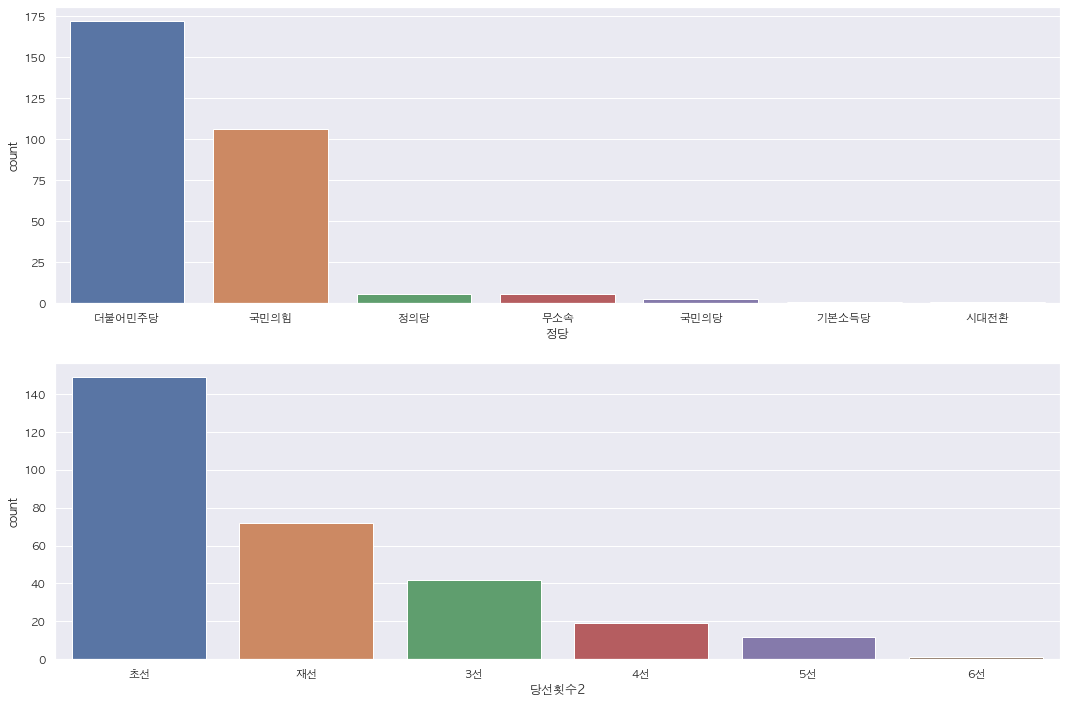

In [195]:
figure,(axes1,axes2) = plt.subplots(nrows=2,ncols=1)
figure.set_size_inches(18,12)

print(members_df['당선횟수2'].head(3))
sns.countplot(data = members_df,x = '정당',ax = axes1,order = members_df['정당'].value_counts().index) ##y축은 자동으로 count생성
sns.countplot(data = members_df,x = '당선횟수2',ax = axes2,order = members_df['당선횟수2'].value_counts().index)



<AxesSubplot:xlabel='count', ylabel='선거구2'>

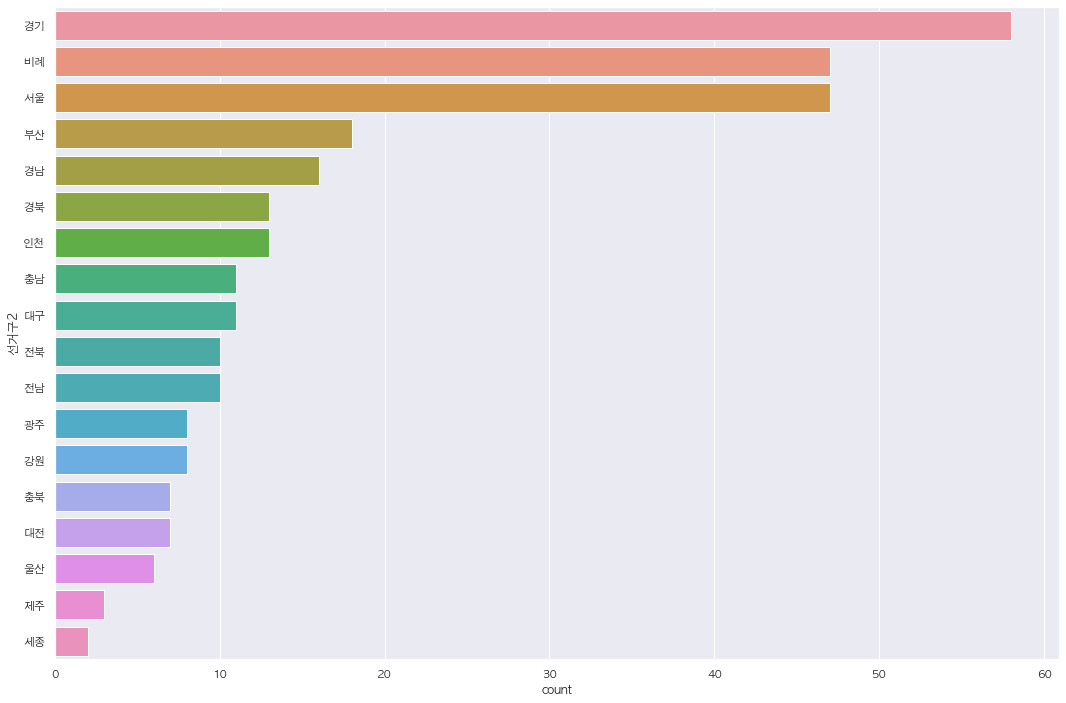

In [196]:
#선거구2 칼럼을 값으로 countplot 그리기
figure,axes1 = plt.subplots(nrows=1,ncols=1)
figure.set_size_inches(18,12)
sns.countplot(data = members_df,y='선거구2',ax = axes1 , order = members_df['선거구2'].value_counts().index)




<AxesSubplot:xlabel='정당', ylabel='나이'>

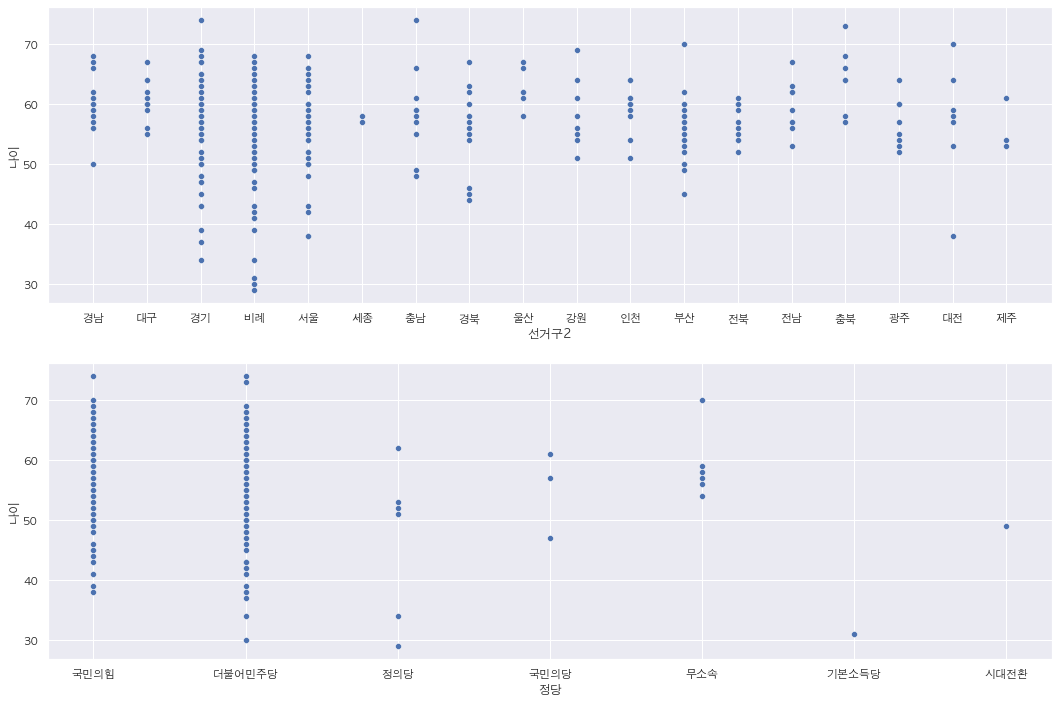

In [197]:
##seaborn의 scatterplot(산점도) 그리기
## 선거구2와 나이 분포를 확인하기
## 정당과 나이분포를 확인하기

figure,(axes1,axes2) = plt.subplots(nrows=2,ncols=1)
figure.set_size_inches(18,12)

sns.scatterplot(data = members_df, x = '선거구2', y = '나이', ax = axes1)
sns.scatterplot(data = members_df, x= '정당', y = '나이', ax = axes2)

/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


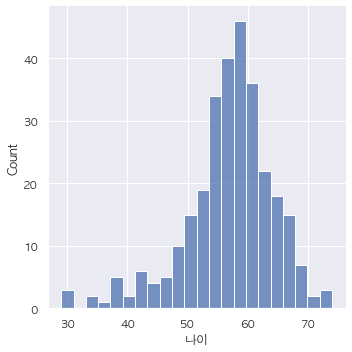

In [198]:
## seaborn 의 distplot() (히스토그램) 그림
# 나이 값의 분포를 확인하기


figure.set_size_inches(18,12)
sns.displot(members_df['나이'],ax = axes1)

[  3.   3.   9.  10.  28.  53. 107.  51.  26.   5.]
[29.  33.5 38.  42.5 47.  51.5 56.  60.5 65.  69.5 74. ]
<BarContainer object of 10 artists>


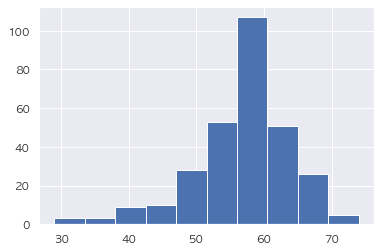

In [199]:
#matplotlib를 사용해서 Histogram 그리기
arrays,bins,patches =plt.hist(members_df['나이'])
print(arrays)
print(bins)
print(patches)

In [200]:
#row count를 %(퍼센테이지) 비율로 나타내려면 normalize = True
cdf = members_df['선거구2'].value_counts(normalize=True)
print(cdf.head())
print(cdf.index)
print(type(cdf))


경기    0.196610
비례    0.159322
서울    0.159322
부산    0.061017
경남    0.054237
Name: 선거구2, dtype: float64
Index(['경기', '비례', '서울', '부산', '경남', '경북', '인천', '충남', '대구', '전북', '전남', '광주',
       '강원', '충북', '대전', '울산', '제주', '세종'],
      dtype='object')
<class 'pandas.core.series.Series'>


([<matplotlib.patches.Wedge at 0x7fda2669a880>,
 [Text(-1.0964410821783328, 0.08841353579405321, '경기'),
  Text(-0.558993202432397, -0.9473788047208853, '비례'),
  Text(0.4961973464985204, -0.981727148105739, '서울'),
  Text(1.0085711994693851, -0.43907190254090045, '부산'),
  Text(1.098705735756011, -0.05334516113803201, '경남'),
  Text(1.0629384676809615, 0.2831286172820574, '경북'),
  Text(0.9450560267646547, 0.5629112774459263, '인천'),
  Text(0.7720442949130896, 0.7835480883086569, '충남'),
  Text(0.5690506386646212, 0.941372068119395, '대구'),
  Text(0.34610272649160323, 1.0441326078209983, '전북'),
  Text(0.11757051320562764, 1.093698849969481, '전남'),
  Text(-0.09295290810353982, 1.0960655805539625, '광주'),
  Text(-0.27746460260261474, 1.064431019043777, '강원'),
  Text(-0.44324411760013505, 1.0067445814171923, '충북'),
  Text(-0.5878695117221238, 0.9297362191436839, '대전'),
  Text(-0.7105495492958838, 0.8397138429223474, '울산'),
  Text(-0.7876477508160356, 0.7678613290395868, '제주'),
  Text(-0.8273986589

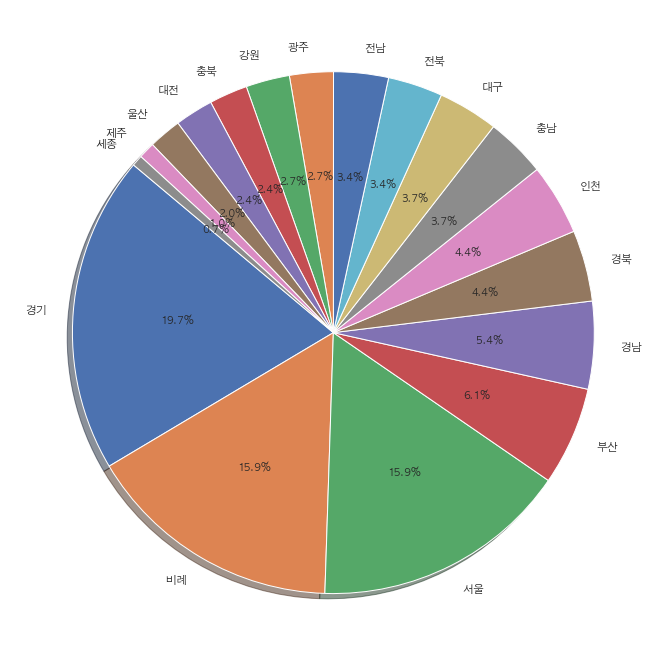

In [201]:
# matplotlib의 pie chart 그리기
# figure size 설정
figure = plt.figure(figsize=(20,12))
##autopct = 퍼센트 계산
plt.pie(cdf,labels=cdf.index,autopct='%1.1f%%',startangle=140,shadow=True)




## pivot table
* 피벗테이블은 표에 데이터를 요약하는 통계표
* index : 행 위치에 들어갈 열
* columns : 열 위치에 들어갈 열
* aggfunc : 집계함수

In [202]:
age_pivot_df = members_df.pivot_table(index='나이',columns='정당',aggfunc='size').fillna(0).astype(int)

/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  fig.canvas.draw()
/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  fig.canvas.draw()
/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 55192 (\N{HANGUL SYLLABLE HIM}) missing from current font.
  fig.canvas.draw()
/Users/jonghwashin/opt/anaconda3/envs/test/lib/pyt

<AxesSubplot:xlabel='정당', ylabel='나이'>

/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  func(*args, **kwargs)
/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  func(*args, **kwargs)
/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  func(*args, **kwargs)
/Users/jonghwashin/opt/anaconda3/envs/test/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  func(*args, **kwargs

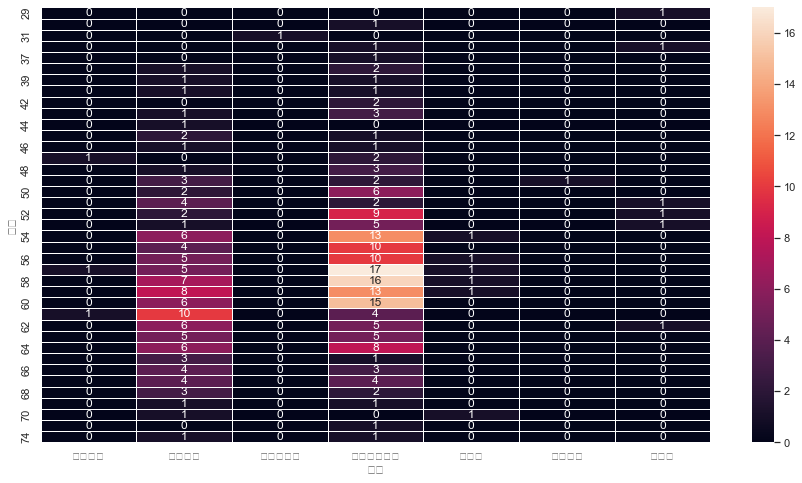

In [203]:
#seaborn의 Heatmap 그리기
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(age_pivot_df,fmt = 'd',linewidths = 1,annot = True)


In [208]:
#나이구간 컬럼을 추가
#해당조건을 만족하는 행을 선택하면서, 새로운 컬럼을 추가하는 방법
members_df.loc[members_df['나이'] < 30,'나이구간'] = 20
members_df.head(3)
members_df.loc[(members_df['나이']>=30) & (members_df['나이']<40),'나이구간'] = 30
members_df.loc[(members_df['나이']>=40) & (members_df['나이']<50),'나이구간'] = 40
members_df.loc[(members_df['나이']>=50) & (members_df['나이']<60),'나이구간'] = 50
members_df.loc[(members_df['나이']>=60) & (members_df['나이']<70),'나이구간'] = 60
members_df.loc[members_df['나이'] > 70,'나이구간'] = 70

In [205]:
members_df['나이구간'] = members_df['나이구간'].fillna(0)

In [207]:
#나이구간 컬럼타입을 float -> int로 변경하기
members_df.head()

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,...,이름,이미지,생년월일,당선횟수2,선거구2,year,month,day,나이,나이구간
0,국민의힘,경남창원시성산구,보건복지위원회,"재선(19대,21대)",02-784-1751,의원회관937호,http://blog.naver.com/ggotop,ggotop@naver.com,"김홍광,한영애","지상훈,최광림",...,강기윤,https://www.assembly.go.kr/photo/9771230.jpg,1960-06-04,재선,경남,1960,6,4,61,60.0
1,국민의힘,대구동구을,"국방위원회,정치개혁특별위원회",초선(21대),02-784-5275,의원회관341호,,kds21341@naver.com,"박홍규,정운태","유진영,윤미라",...,강대식,https://www.assembly.go.kr/photo/9771142.jpg,1959-11-02,초선,대구,1959,11,2,62,60.0
2,더불어민주당,경기안양시만안구,"교육위원회,예산결산특별위원회",초선(21대),02-784-2747~9,의원회관440호,https://blog.naver.com/dulipapa,mainsail440@daum.net,"서용선,안홍식","최경순,홍미하",...,강득구,https://www.assembly.go.kr/photo/9771174.jpg,1963-05-27,초선,경기,1963,5,27,58,50.0
3,국민의힘,경남진주시을,"국회운영위원회,정무위원회,중앙선거관리위원회위원(문상부)선출에관한인사청문특별위원회,정...",초선(21대),02-784-0797,의원회관1007호,,strongwind01@naver.com,"강민승,정경섭","국고은,오경훈",...,강민국,https://www.assembly.go.kr/photo/9771233.jpg,1971-03-03,초선,경남,1971,3,3,50,50.0
4,더불어민주당,비례대표,"국회운영위원회,교육위원회,예산결산특별위원회",초선(21대),02-784-2477,의원회관421호,https://blog.naver.com/kmgedu21,kmj2020edu@gmail.com,"손성조,윤호숙","김민혜,김원석",...,강민정,https://www.assembly.go.kr/photo/9771283.jpg,1961-04-26,초선,비례,1961,4,26,60,60.0


### mission3
    * 선거구3 칼럼을 새로생성
    * 서울 경기 인천 -> 수도권
    * 충남 충북 대전 세종 -> 충청
    * 경남 경북 대구 울산 부산 -> 경상
    * 광주 전남 전북 -> 전라
    * 비례
    * 강원
    * 제주
2. Pivot table 만들기
    행은 선거구3,열은나이구간
3. 생성한 pivot table을 사용하여 heatmap그리기

In [210]:
members_df.loc[members_df['선거구2'].isin(['서울','경기','인천']),'선거구3']= '수도권'
members_df.loc[members_df['선거구2'].isin(['충남','충북','대전','세종']),'선거구3']= '충청'
members_df.loc[members_df['선거구2'].isin(['경남','경북','대구','울산','부산']),'선거구3']= '경상'
members_df.loc[members_df['선거구2'].isin(['광주','전남','전북']),'선거구3']= '전라'
members_df.loc[members_df['선거구2'].isin(['비례']),'선거구3']= '비례'
members_df.loc[members_df['선거구2'].isin(['강원']),'선거구3']= '강원'
members_df.loc[members_df['선거구2'].isin(['제주']),'선거구3']= '제주'

In [211]:
members_df.head()

,정당,선거구,소속위원회,당선횟수,사무실 전화,사무실 호실,홈페이지,이메일,보좌관,비서관,...,이미지,생년월일,당선횟수2,선거구2,year,month,day,나이,나이구간,선거구3
0,국민의힘,경남창원시성산구,보건복지위원회,"재선(19대,21대)",02-784-1751,의원회관937호,http://blog.naver.com/ggotop,ggotop@naver.com,"김홍광,한영애","지상훈,최광림",...,https://www.assembly.go.kr/photo/9771230.jpg,1960-06-04,재선,경남,1960,6,4,61,60.0,경상
1,국민의힘,대구동구을,"국방위원회,정치개혁특별위원회",초선(21대),02-784-5275,의원회관341호,,kds21341@naver.com,"박홍규,정운태","유진영,윤미라",...,https://www.assembly.go.kr/photo/9771142.jpg,1959-11-02,초선,대구,1959,11,2,62,60.0,경상
2,더불어민주당,경기안양시만안구,"교육위원회,예산결산특별위원회",초선(21대),02-784-2747~9,의원회관440호,https://blog.naver.com/dulipapa,mainsail440@daum.net,"서용선,안홍식","최경순,홍미하",...,https://www.assembly.go.kr/photo/9771174.jpg,1963-05-27,초선,경기,1963,5,27,58,50.0,수도권
3,국민의힘,경남진주시을,"국회운영위원회,정무위원회,중앙선거관리위원회위원(문상부)선출에관한인사청문특별위원회,정...",초선(21대),02-784-0797,의원회관1007호,,strongwind01@naver.com,"강민승,정경섭","국고은,오경훈",...,https://www.assembly.go.kr/photo/9771233.jpg,1971-03-03,초선,경남,1971,3,3,50,50.0,경상
4,더불어민주당,비례대표,"국회운영위원회,교육위원회,예산결산특별위원회",초선(21대),02-784-2477,의원회관421호,https://blog.naver.com/kmgedu21,kmj2020edu@gmail.com,"손성조,윤호숙","김민혜,김원석",...,https://www.assembly.go.kr/photo/9771283.jpg,1961-04-26,초선,비례,1961,4,26,60,60.0,비례


<AxesSubplot:xlabel='나이', ylabel='선거구3'>

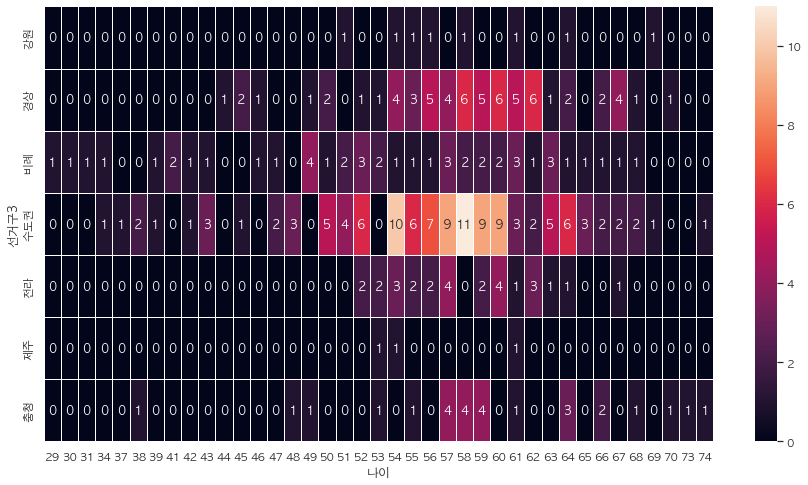

In [217]:
plt.rcParams['font.family'] = 'AppleGothic'
loca_age_pivot= members_df.pivot_table(index='선거구3',columns='나이',aggfunc='size').fillna(0).astype(int)
sns.heatmap(loca_age_pivot,fmt = 'd',linewidths = 1,annot = True)

In [ ]:
#인덱스 1부터 시작

# df.index = np.arange()